<a href="https://colab.research.google.com/github/Oyekanmi/Machine-Learning-New/blob/master/Product_Backorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Products Backorder**




Material backorder is a common inventory problem in which demands for products cannot be fulfilled due to material or product shortage. Identifying these shortages, when and where before it happens would provide an opportunity for manufacturers to mitigate it, maximize their sales, and overall performance. 






**Why it is important?**



Regular backorders are indications that demand for a product exceeds the supply and the company is losing out on potential opportunities. Also, if a customer noticed that a product or series of products are on backorder regularly, He or She might consider it a high risk to continue doing business with the manufacturer, thereby, leading to order cancellation and a potential drop in sales.




**Data Source:** Kaggle

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve

%matplotlib inline 

In [ ]:
#read the data
order_df = pd.read_csv('Training_Dataset.csv')

#view the first five row
order_df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0,NaN,0,0,0,0,0,0,0,0,0,No,0,-99.00,-99.00,0,No,No,No,Yes,No,No
1,1043384,2,9.0,0,0,0,0,0,0,0,0,0,No,0,0.99,0.99,0,No,No,No,Yes,No,No
2,1043696,2,NaN,0,0,0,0,0,0,0,0,0,No,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No
3,1043852,7,8.0,0,0,0,0,0,0,0,0,1,No,0,0.10,0.13,0,No,No,No,Yes,No,No
4,1044048,8,NaN,0,0,0,0,0,0,0,4,2,No,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No


In [ ]:
#check the size of the dataset
order_df.shape

(1048575, 23)

In [ ]:
#drop the 'sku' column since it's not useful in this situaton
product_order = order_df.drop(labels=['sku'], axis=1)
product_order.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0,NaN,0,0,0,0,0,0,0,0,0,No,0,-99.00,-99.00,0,No,No,No,Yes,No,No
1,2,9.0,0,0,0,0,0,0,0,0,0,No,0,0.99,0.99,0,No,No,No,Yes,No,No
2,2,NaN,0,0,0,0,0,0,0,0,0,No,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No
3,7,8.0,0,0,0,0,0,0,0,0,1,No,0,0.10,0.13,0,No,No,No,Yes,No,No
4,8,NaN,0,0,0,0,0,0,0,4,2,No,0,-99.00,-99.00,0,Yes,No,No,Yes,No,No


In [ ]:
#split into feature and response set
X= product_order.loc[:, :'rev_stop']        
y = product_order.loc[:,'went_on_backorder']

**Split the dataset into training and testing set**

In [ ]:
#First divide the data into training and testing 
#Since we have a relatively large dataset, we can afford to split using the 80:20 training and testing
#note : we stratify the split because of the uneven class distribution
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

In [ ]:
#verify the size of the training and testing dataset
print( f'Training size : {X_train.shape}')
print( f'Testing size : {X_test.shape}')

print('\n')

print( f'Training size : {y_train.shape}')
print( f'Testing size : {y_test.shape}')

Training size : (838860, 21)
Testing size : (209715, 21)


Training size : (838860,)
Testing size : (209715,)


In [ ]:
#check for missing values in the training dataset
X_train.isna().sum()  

national_inv             0
lead_time            51671
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
stop_auto_buy            0
rev_stop                 0
dtype: int64

**Comment:** The training dataset has obver 51,671 missing values . How do we input missing ? 

Text(0, 0.5, 'count in %')

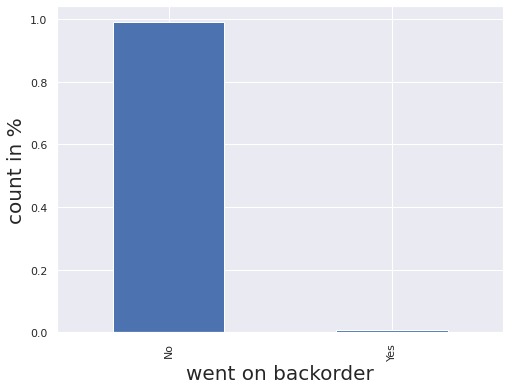

In [ ]:
#Let's visualize the class distribution
#set figure size
sns.set(rc={'figure.figsize':(8,6)})   
#Let's check the distribution of the dataset
b=y_train.value_counts(normalize=True).plot(kind='bar')
b.set_xlabel("went on backorder", fontsize=20)
b.set_ylabel("count in %", fontsize=20)

**Comment** : Only less than 1% of the observations / products is on backorder. This is an imbalance class problem with a ratio of about 1:100 for product that went on backorder against products that did not

**Get the categorical and numerical columns**

In [ ]:
#extract numerical columns
categorical_col = [col for col in X_train.columns if X_train[col].dtypes =='object']   

#extract categorical columns
numerical_col = list( set(X_train.columns)- set(categorical_col))  

In [ ]:
#display the numerical columns and categorical columns
#This will be useful in subsequent cells
print(f'numerical columns : {numerical_col}')
print(f'categorical columns : {categorical_col}')

numerical columns : ['local_bo_qty', 'forecast_6_month', 'perf_12_month_avg', 'forecast_9_month', 'perf_6_month_avg', 'sales_9_month', 'min_bank', 'sales_3_month', 'forecast_3_month', 'national_inv', 'sales_6_month', 'in_transit_qty', 'lead_time', 'sales_1_month', 'pieces_past_due']
categorical columns : ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']


**Preprocessing of Training Data**


**Data Imputation**


The dataset has series of missing values . It begged a question of what is the best method to impute the missing values ? A good approach is to check for the distribution of the column with missing values

**Check for the distribution of the dataset in column 'lead time'**

Text(0.5, 1.0, 'Distribution of the Lead Time column')

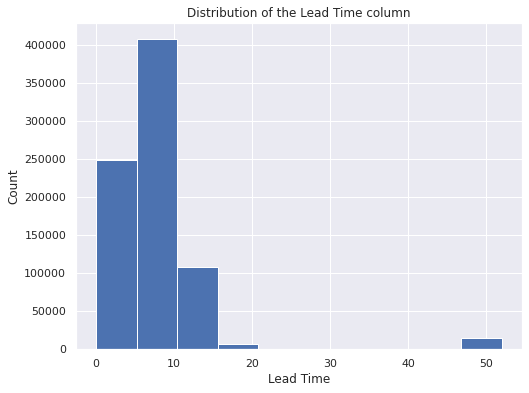

In [ ]:
#plot an histogram to visualize the distribution of values in lead_time column
plt.hist(X_train.lead_time.values)
plt.xlabel('Lead Time')
plt.ylabel('Count')
plt.title('Distribution of the Lead Time column' )

**Comment:** From the histogram above, the distribution of the lead time data is skewed to the right. The common form of imputation is with the mean value of the columns with missing values in the training set. However, in this case, as seen in the histogram above, the dataset is skewed to the right and imputation with the mean might affect the distribution. Hence,the preferred approach is to replace the missing values with the median. 

In [ ]:
#fill missing value with mean
X_train_filled = X_train.fillna(X_train['lead_time'].median())
X_train_filled.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
719765,3,6.0,0,0,0,0,0,0,1,3,0,No,0,0.79,0.66,0,No,No,No,Yes,No
984611,5,9.0,0,0,0,0,0,0,0,0,0,No,0,0.68,0.66,0,Yes,No,No,Yes,No
848050,0,8.0,0,0,0,0,0,0,0,0,0,No,0,0.62,0.52,0,No,No,Yes,Yes,No
427426,4,8.0,0,0,0,0,0,0,0,1,0,No,0,0.79,0.66,0,No,No,No,Yes,No
21506,587,8.0,0,0,0,0,0,0,1,1,0,No,0,-99.00,-99.00,0,Yes,No,Yes,Yes,No


**Convert categorical to dummies and Scale numerical features**

In [ ]:
#Initiate One Hot Encoder categorical column to dummies 
ohe = OneHotEncoder(handle_unknown='ignore') 

#initiate feature scaling object
feature_scaling = StandardScaler()       

# The response variable is in {'yes', 'no'}. We have to convert to numerical features 
#This code encodes class [ went on backorder or not] values as integers of 0 and 1
le = LabelEncoder()
label_encoded_y_train= le.fit_transform(y_train)

**Build a pipeline of preprocessing step :** 

To ensure the code is more readable and prevent data leakage, we will build a pipeline of preprocessing steps. This pipeline has two steps (transformers) : first step will convert categorical features to dummies using the OneHotEncoder object and the second step uses StandardScaler() to scale the numerical features so that it will have a mean value of zero and standard deviation of 1.


In [ ]:
#This is a pipeline of preprocessing transformers: The first one converts to dummies and the second one scales numerical features
ct = make_column_transformer((ohe,categorical_col),(feature_scaling, numerical_col ), remainder='passthrough')  #ct is a transformer

#Encode categorical features as integers, impute missing values and scale
X_train_preprocessed = ct.fit_transform(X_train_filled)

**Let's visualize the preprocessed training data**

The data is of high dimension. We first reduce the dimension to 2 principal components using PCA so we can visualize the data

In [ ]:
#Retrieve the first two principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  
X_train_pca = pca.fit_transform(X_train_preprocessed)  

#concatenate the two principal components with their labels
Top2_principal_component_and_label = np.concatenate((X_train_pca,label_encoded_y_train.reshape(-1,1)), axis=1)   
Top2_principal_component_and_label

array([[-0.10055438, -0.46783788,  0.        ],
       [-0.10868022, -0.25944886,  0.        ],
       [-0.1025187 , -0.4150185 ,  0.        ],
       ...,
       [-0.09786616, -0.43230225,  1.        ],
       [-0.09984969, -0.45783119,  0.        ],
       [-0.1084719 , -0.26650435,  0.        ]])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Principal Component 1 vs Principal Component 2')

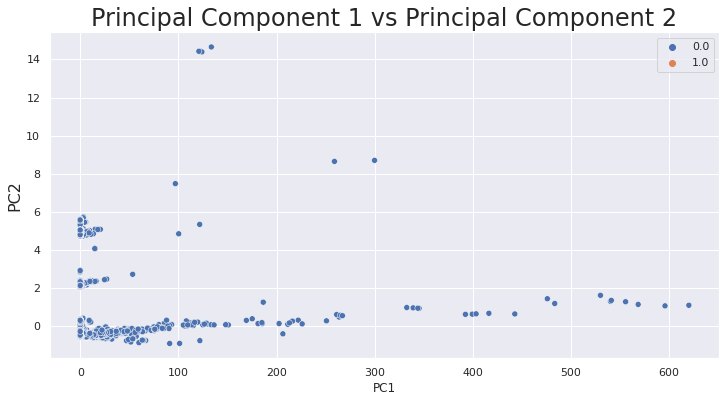

In [ ]:
#view the first two principal components
sns.set(rc={'figure.figsize':(12,6)})   #set figure size
sns.scatterplot(Top2_principal_component_and_label[:,0], Top2_principal_component_and_label[:,1], hue= Top2_principal_component_and_label[:,2] )  #[:10000]  [:10000]
plt.xlabel("PC1", size=12)
plt.ylabel("PC2", size=16)
plt.title("Principal Component 1 vs Principal Component 2", size=24)

**Preprocess the Test Set**

In [ ]:
#check for missing values in the testing data
X_test.isna().sum()

national_inv             0
lead_time            12847
in_transit_qty           0
forecast_3_month         0
forecast_6_month         0
forecast_9_month         0
sales_1_month            0
sales_3_month            0
sales_6_month            0
sales_9_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_6_month_avg         0
perf_12_month_avg        0
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
stop_auto_buy            0
rev_stop                 0
dtype: int64

**Comment:** The test data has 12,847 missing values. Since the data distribution of the column with the missing is skewed , the first feasible technique would be to try the median.

In [ ]:
#fill the missing value with the median of the training 
#Note: We filled with the median of training to prevent data leakage i.e. We assume the test set is a dataset that hasn't been 
#seen before. So the imputation is done with the median of the training data
X_test_filled_missing =X_test.fillna(X_train['lead_time'].median())
X_test_filled_missing.head()

#Convert the categorical columns to dummies and scale the numerical features using the previously defined column transformer
X_test_preprocessed = ct.transform(X_test_filled_missing)

#Encode class [went on backorder or not] values as integers of 0 and 1
label_encoded_y_test = le.transform(y_test)

**Model Building**

We will apply the Stratified K-Fold technique here with cv=5. This is important because of the wide margin of uneven classes. This will split the X_train datset into 5 folds using 4 random folds for training and the last one for testing. This helps in model generalization and prevents overfitting

In [ ]:
#import library
from sklearn.model_selection import StratifiedKFold

#define the stratified Kfold object
#set random state for reproducibility
kfold = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=0)

**Model 1: Logistic Regression**

In [ ]:
# Split the training dataset into training and validation dataset
#using a stratified CV=5
training_auc_list = []
validation_auc_list = []

#For each folds in Kfolds, selects n-1 folds as the training set and the last fold as the validation set
for train_index, val_index in kfold.split(X_train_preprocessed,label_encoded_y_train):
    X_train_cv, X_val_cv =X_train_preprocessed[train_index], X_train_preprocessed[val_index]
    y_train_cv, y_val_cv = label_encoded_y_train[train_index], label_encoded_y_train[val_index]
  
    #initialize logistic regression
    log_reg = LogisticRegression(max_iter=100, random_state=0, n_jobs=-1)

    #Training with the training split 
    log_reg.fit(X_train_cv,y_train_cv)

    #create training and validation predictions probabilities
    train_predictions_proba = log_reg.predict_proba(X_train_cv)
    val_predictions_proba = log_reg.predict_proba(X_val_cv)

    #create training and validation predictions 
    train_predictions= log_reg.predict(X_train_cv)
    val_predictions= log_reg.predict(X_val_cv)
                                     
    #calculate testing AUC Scores
    # We chose AUC because of the imbalance dataset
    training_auc= roc_auc_score(y_train_cv,train_predictions_proba[:,1])
    validation_auc= roc_auc_score(y_val_cv,val_predictions_proba[:,1])

    #append training and validation auc into list
    training_auc_list.append(training_auc)
    validation_auc_list.append(validation_auc)

    #view the training and validation AUC
    print(f'Training AUC: {training_auc}')
    print(f'Validation AUC: {validation_auc}')

print('\n')


#view training and validation auc
print(f'Training AUC List: {training_auc_list}')
print(f'Validation AUC List: {validation_auc_list}')

print('\n')
#Get the mean training and validtaion auc score
print(f'Mean training auc score: {np.mean(training_auc_list)}')
print(f'Mean validation auc score: {np.mean(validation_auc_list)}')

Training AUC: 0.6726999522208653
Validation AUC: 0.6779874271292103
Training AUC: 0.6703294579326964
Validation AUC: 0.6873411492267598
Training AUC: 0.6740487703641047
Validation AUC: 0.6581141984767009
Training AUC: 0.6741301986146107
Validation AUC: 0.6764020623443259
Training AUC: 0.6753225151479094
Validation AUC: 0.6649241319909285


Training AUC List: [0.6726999522208653, 0.6703294579326964, 0.6740487703641047, 0.6741301986146107, 0.6753225151479094]
Validation AUC List: [0.6779874271292103, 0.6873411492267598, 0.6581141984767009, 0.6764020623443259, 0.6649241319909285]


Mean training auc score: 0.6733061788560374
Mean validation auc score: 0.672953793833585


**Make predictions on test data**

In [ ]:
#finally retrain on the whole training and test on the testing data
#initialize logistic regression
log_reg = LogisticRegression(max_iter=100,random_state=0, n_jobs=-1)

#Training with the whole training set
log_reg.fit(X_train_preprocessed,label_encoded_y_train)

#create training and testing predictions probabilities
train_predictions_proba = log_reg.predict_proba(X_train_preprocessed)
test_predictions_proba = log_reg.predict_proba(X_test_preprocessed)

#create training and validation predictions 
train_predictions= log_reg.predict(X_train_preprocessed)
test_predictions= log_reg.predict(X_test_preprocessed)

#calculate training and testing AUC Scores
# We chose AUC because of the imbalance dataset
training_auc= roc_auc_score(label_encoded_y_train,train_predictions_proba[:,1])
testing_auc= roc_auc_score(label_encoded_y_test,test_predictions_proba[:,1])

 #view training auc
print(f'Training AUC: {training_auc}')
print(f'Testing AUC: {validation_auc}')

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(label_encoded_y_test, test_predictions_proba[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(label_encoded_y_train, train_predictions_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(label_encoded_y_test))]
p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

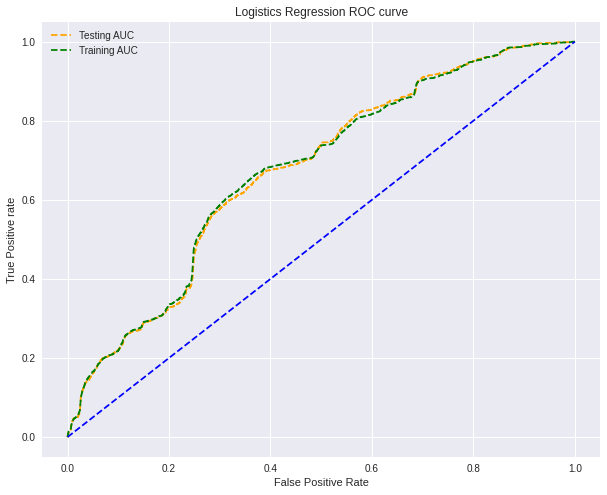

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,8))
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Logistics Regression ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

***The Linear Classifier didn't perform well on the dataset. Let's try PCA to reduce the dimension and retrain the model.***

Remember: Don't scale features before fitting the PCA . i.e. Fit the PCA on unscaled dataset

In [ ]:
#don't scale a feature if before using PCA
X_train_dummy_coded = pd.get_dummies(X_train_filled, dummy_na=True)


#initialize PCA
pca = PCA()    

#fit on the training data
pca.fit(X_train_dummy_coded)  

#check the explained variance by each feature
pca.explained_variance_ratio_  [:4].sum()

0.9977068433385539

First 4 features were able to explain over 99% of the variance . So I will get the first 4 features and fit the model on them.

**Perform the Logistic Regression Using the First 4 features**

In [ ]:
X_train_dummy_coded.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_No,potential_issue_Yes,potential_issue_nan,deck_risk_No,deck_risk_Yes,deck_risk_nan,oe_constraint_No,oe_constraint_Yes,oe_constraint_nan,ppap_risk_No,ppap_risk_Yes,ppap_risk_nan,stop_auto_buy_No,stop_auto_buy_Yes,stop_auto_buy_nan,rev_stop_No,rev_stop_Yes,rev_stop_nan
719765,3,6.0,0,0,0,0,0,0,1,3,0,0,0.79,0.66,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
984611,5,9.0,0,0,0,0,0,0,0,0,0,0,0.68,0.66,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0
848050,0,8.0,0,0,0,0,0,0,0,0,0,0,0.62,0.52,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
427426,4,8.0,0,0,0,0,0,0,0,1,0,0,0.79,0.66,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
21506,587,8.0,0,0,0,0,0,0,1,1,0,0,-99.00,-99.00,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0


In [ ]:
#Retrieve the first 4 principal components
pca = PCA(n_components=4)  
X_train_pca_for_logreg = pca.fit_transform(X_train_dummy_coded)  

#Scale numnerical features  
sc= StandardScaler()
X_train_pca_scaled = sc.fit_transform(X_train_pca_for_logreg)

In [ ]:
#testing preprocessing
X_test_dummy_coded = pd.get_dummies(X_test_filled_missing, dummy_na=True)
X_test_pca_for_logreg= pca.transform(X_test_dummy_coded)
X_test_pca_scaled = sc.transform(X_test_pca_for_logreg)

In [ ]:
# Split the training dataset into training and validation dataset
#using a stratified CV=5
training_auc_list = []
validation_auc_list = []

#For each folds in Kfolds, selects n-1 folds as the training set and the last fold as the validation set
for train_index, val_index in kfold.split(X_train_pca_scaled,label_encoded_y_train):
    X_train_cv, X_val_cv =X_train_pca_scaled[train_index], X_train_pca_scaled[val_index]
    y_train_cv, y_val_cv = label_encoded_y_train[train_index], label_encoded_y_train[val_index]
  
    #initialize logistic regression
    log_reg = LogisticRegression(max_iter=100, random_state=0, n_jobs=-1)

    #Training with the training split 
    log_reg.fit(X_train_cv,y_train_cv)

    #create training and validation predictions probabilities
    train_predictions_proba = log_reg.predict_proba(X_train_cv)
    val_predictions_proba = log_reg.predict_proba(X_val_cv)

    #create training and validation predictions 
    train_predictions= log_reg.predict(X_train_cv)
    val_predictions= log_reg.predict(X_val_cv)
                                     
    #calculate testing AUC Scores
    # We chose AUC because of the imbalance dataset
    training_auc= roc_auc_score(y_train_cv,train_predictions_proba[:,1])
    validation_auc= roc_auc_score(y_val_cv,val_predictions_proba[:,1])

    #append training and validation auc into list
    training_auc_list.append(training_auc)
    validation_auc_list.append(validation_auc)

    #view the training and validation AUC
    print(f'Training AUC: {training_auc}')
    print(f'Validation AUC: {validation_auc}')

print('\n')


#view training and validation auc
print(f'Training AUC List: {training_auc_list}')
print(f'Validation AUC List: {validation_auc_list}')

print('\n')
#Get the mean training and validtaion auc score
print(f'Mean training auc score: {np.mean(training_auc_list)}')
print(f'Mean validation auc score: {np.mean(validation_auc_list)}')

Training AUC: 0.8219349730427556
Validation AUC: 0.8335417613420681
Training AUC: 0.8211012141309688
Validation AUC: 0.8285866417883128
Training AUC: 0.8207891069360854
Validation AUC: 0.8186982450051239
Training AUC: 0.8212064371748727
Validation AUC: 0.8101957213259168
Training AUC: 0.8215780425667557
Validation AUC: 0.8155598272154787


Training AUC List: [0.8219349730427556, 0.8211012141309688, 0.8207891069360854, 0.8212064371748727, 0.8215780425667557]
Validation AUC List: [0.8335417613420681, 0.8285866417883128, 0.8186982450051239, 0.8101957213259168, 0.8155598272154787]


Mean training auc score: 0.8213219547702877
Mean validation auc score: 0.82131643933538


**Evaluate the model generalization on the test set**

In [ ]:
#finally retrain on the whole training and test on the testing data
#initialize logistic regression
log_reg = LogisticRegression(max_iter=100, C=1,random_state=0, n_jobs=-1)

#Training with the whole training set
log_reg.fit(X_train_pca_scaled,label_encoded_y_train)

#create training and testing predictions probabilities
train_predictions_proba = log_reg.predict_proba(X_train_pca_scaled)
test_predictions_proba = log_reg.predict_proba(X_test_pca_scaled)

#create training and validation predictions 
train_predictions= log_reg.predict(X_train_pca_scaled)
test_predictions= log_reg.predict(X_test_pca_scaled)

#calculate training and testing AUC Scores
# We chose AUC because of the imbalance dataset
training_auc= roc_auc_score(label_encoded_y_train,train_predictions_proba[:,1])
testing_auc= roc_auc_score(label_encoded_y_test,test_predictions_proba[:,1])

 #view training auc
print(f'Training AUC: {training_auc}')
print(f'Testing AUC: {validation_auc}')

Training AUC: 0.8195225961082533
Testing AUC: 0.8155598272154787


**Visualization**

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(label_encoded_y_test, test_predictions_proba[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(label_encoded_y_train, train_predictions_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(label_encoded_y_test))]
p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

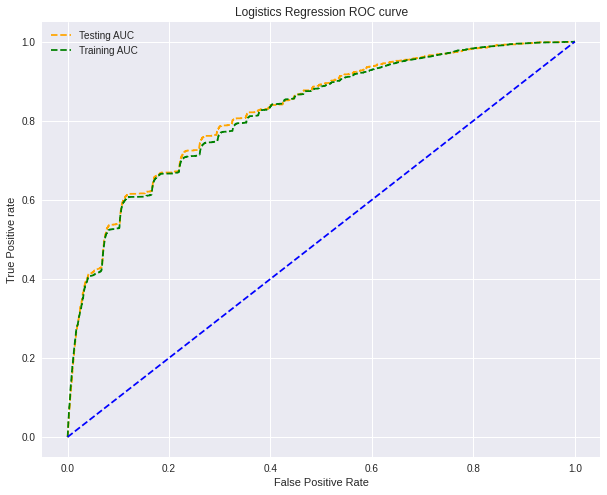

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,8))
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Logistics Regression ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
#confusion matrix
confusion_matrix(label_encoded_y_test,test_predictions)

array([[207934,      1],
       [  1780,      0]])

**Tune Hyperparamter**

In [ ]:
#impport RandomSearchCV
from sklearn.model_selection import RandomizedSearchCV

#define the hyperparamters and searched space
C = [10,100,1000,10001]
# penalty = ['l1', 'l2']

random_space = dict(C=C)

randomsearch_logreg = RandomizedSearchCV(estimator=log_reg,param_distributions= random_space,cv=kfold, 
                                        scoring='roc_auc',random_state=0, n_jobs=-1)

#fit the random search cv
randomsearch_logreg.fit(X_train_pca_for_logreg, label_encoded_y_train)  #X_train_preprocessed
randomsearch_logreg.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'C': 100}

In [ ]:
best_params={'C': 100, 'penalty': 'l2'}
# best_params={'C': 100, 'penalty': 'l2'}

**Visualize best params**

In [ ]:
#finally retrain on the whole training and test on the testing data
#initialize logistic regression
log_reg_bestparams = LogisticRegression(max_iter=100, **best_params, random_state=0, n_jobs=-1)

#Training with the whole training set
log_reg_bestparams.fit(X_train_preprocessed,label_encoded_y_train)

#create training and testing predictions probabilities
train_predictions_proba_tuned = log_reg_bestparams.predict_proba(X_train_preprocessed)
test_predictions_proba_tuned = log_reg_bestparams.predict_proba(X_test_preprocessed)

#create training and validation predictions 
train_predictions_tuned= log_reg_bestparams.predict(X_train_preprocessed)
test_predictions_tuned= log_reg_bestparams.predict(X_test_preprocessed)

#calculate training and testing AUC Scores
# We chose AUC because of the imbalance dataset
training_auc_tuned= roc_auc_score(label_encoded_y_train,train_predictions_proba_tuned[:,1])
testing_auc_tuned= roc_auc_score(label_encoded_y_test,test_predictions_proba_tuned[:,1])

 #view training auc
print(f'Training AUC: {training_auc_tuned}')
print(f'Testing AUC: {testing_auc_tuned}')

Training AUC: 0.6817575444418267
Testing AUC: 0.6812018381392413


In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr_1, tpr_1, thresh_1 = roc_curve(label_encoded_y_test, test_predictions_proba_tuned[:,1], pos_label=1)
fpr_2, tpr_2, thresh_2 = roc_curve(label_encoded_y_train, train_predictions_proba_tuned[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(label_encoded_y_test))]
p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

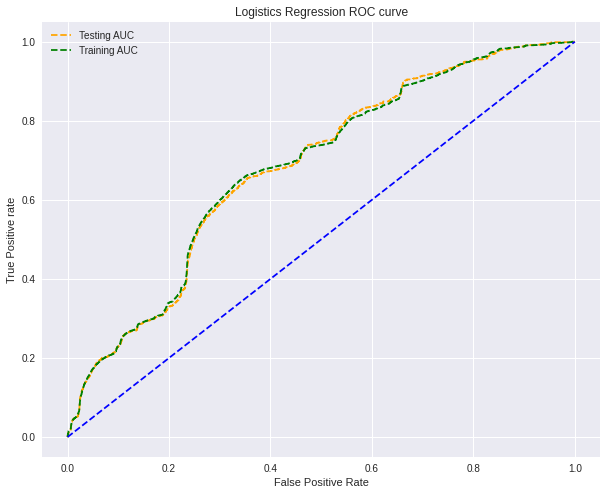

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,8))
# plot roc curves
plt.plot(fpr_1, tpr_1, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr_2, tpr_2, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Logistics Regression ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**Model2 : Support Vector Machine**    Too slow and we didn't use it eventually

In [ ]:
# # #import library
# from sklearn.svm import SVC

# # # Split the training dataset into training and validation dataset
# # #using a stratified CV=5
# svm_training_auc_list = []
# svm_validation_auc_list = []

# #For each folds in Kfolds, selects n-1 folds as the training set and the last fold as the validation set
# for train_index, val_index in kfold.split(X_train_pca_scaled,label_encoded_y_train):
#      X_train_cv, X_val_cv =X_train_pca_scaled[train_index], X_train_pca_scaled[val_index]
#      y_train_cv, y_val_cv = label_encoded_y_train[train_index], label_encoded_y_train[val_index]
  
#      #initialize logistic regression
#      svm_clf = SVC(random_state=0, probability=True)

#      #Training with the training split 
#      svm_clf .fit(X_train_cv,y_train_cv)

#      #create training and validation predictions probabilities
#      svm_train_predictions_proba = svm_clf.predict_proba(X_train_cv)
#      svm_val_predictions_proba = svm_clf.predict_proba(X_val_cv)

#      #create training and validation predictions 
#      svm_train_predictions= svm_clf .predict(X_train_cv)
#      svm_val_predictions= svm_clf.predict(X_val_cv)
                                     
#      #calculate testing AUC Scores
#      # We chose AUC because of the imbalance dataset
#      svm_training_auc= roc_auc_score(y_train_cv,svm_train_predictions_proba[:,1])
#      svm_validation_auc= roc_auc_score(y_val_cv,svm_val_predictions_proba[:,1])

#      #append training and validation auc into list
#      svm_training_auc_list.append(svm_training_auc)
#      svm_validation_auc_list.append(svm_validation_auc)

# #     #view the training and validation AUC
#      print(f'Training AUC: {svm_training_auc}')
#      print(f'Validation AUC: {svm_validation_auc}')

# print('\n')


# # #view training and validation auc
# print(f'Training AUC List: {svm_training_auc_list}')
# print(f'Validation AUC List: {svm_validation_auc_list}')

# print('\n')
# #Get the mean training and validtaion auc score
# print(f'Mean training auc score: {np.mean(svm_training_auc_list)}')
# print(f'Mean validation auc score: {np.mean(svm_validation_auc_list)}')

In [ ]:
# # roc curve for models
# fpr_svm_test, tpr_svm_test, thresh1 = roc_curve(label_encoded_y_test, svm_test_predictions_proba[:,1], pos_label=1)
# fpr_svm_train, tpr_svm_train, thresh2 = roc_curve(label_encoded_y_train, svm_train_predictions_proba[:,1], pos_label=1)

# # # roc curve for tpr = fpr 
# # random_probs = [0 for i in range(len(label_encoded_y_test))]
# # p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)


# #plot
# plt.style.use('seaborn')
# plt.figure(figsize=(10,8))
# # plot roc curves
# plt.plot(fpr_svm_test, tpr_svm_test, linestyle='--',color='orange', label='Testing AUC')
# plt.plot(fpr_svm_train, tpr_svm_train, linestyle='--',color='green', label='Training AUC')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
# plt.title('SVM ROC curve')
# # x label
# plt.xlabel('False Positive Rate')
# # y label
# plt.ylabel('True Positive rate')

# plt.legend(loc='best')
# plt.savefig('SVM_ROC',dpi=300)
# plt.show();

**Fit on Full Training Dataset**

In [ ]:
# from sklearn.svm import SVC
# #fit on the training set
# svm = SVC(random_state=0)
# svm.fit(X_train_preprocessed,label_encoded_y_train)

In [ ]:
# #create training and testing predictions probabilities
# svm_train_predictions_proba = svm.predict_proba(X_train_preprocessed)
# svm_test_predictions_proba = svm.predict_proba(X_test_preprocessed)

# #create training and testing predictions 
# svm_train_predictions= svm.predict(X_train_preprocessed)
# svm_test_predictions= svm.predict(X_test_preprocessed)

In [ ]:
# #calculate training and testing AUC Scores 
# training_auc= roc_auc_score(label_encoded_y_train,svm_train_predictions_proba[:,1])
# testing_auc= roc_auc_score(label_encoded_y_test,svm_test_predictions_proba[:,1])

# #view training auc
# print(f'Training AUC: {training_auc}')
# print(f'Testing AUC: {testing_auc}')

SVM Output :Run Time Disconnected

**Decision Trees**

In [ ]:
tree_training_auc_list = []
tree_validation_auc_list=[]
i=1
#Split into traning and validation using Stratified KFold
for train_index, val_index in kfold.split(X_train_preprocessed,label_encoded_y_train):
    X_train_tree, X_val_tree =X_train_preprocessed[train_index], X_train_preprocessed[val_index]
    y_train_tree, y_val_tree = label_encoded_y_train[train_index], label_encoded_y_train[val_index]


    #initialize the model
    tree_clf = DecisionTreeClassifier(random_state=0)

    #fit the model on the training set
    tree_clf.fit(X_train_tree,y_train_tree)

    #create training and testing predictions probabilities
    tree_train_predictions_proba = tree_clf.predict_proba(X_train_tree)
    tree_val_predictions_proba = tree_clf.predict_proba(X_val_tree)

    #calculate training and testing AUC Scores 
    tree_training_auc= roc_auc_score(y_train_tree,tree_train_predictions_proba[:,1])
    tree_validation_auc= roc_auc_score(y_val_tree,tree_val_predictions_proba[:,1])

    #append training and testing auc
    tree_training_auc_list.append(tree_training_auc)
    tree_validation_auc_list.append(tree_validation_auc)

    #print training and validation auc
    print(f"{i}--Fold")
    print(f"Training AUC: {tree_training_auc}")
    print(f"Validation AUC: {tree_validation_auc}")

    i = i+1

    print('\n')

1--Fold
Training AUC: 0.9999424000514826
Validation AUC: 0.7030741577052628


2--Fold
Training AUC: 0.9999446868149261
Validation AUC: 0.6881403908599085


3--Fold
Training AUC: 0.9999512328632739
Validation AUC: 0.6963224436527135


4--Fold
Training AUC: 0.9999437583367264
Validation AUC: 0.6866124814352907


5--Fold
Training AUC: 0.9999444787714307
Validation AUC: 0.6992157579730647




In [ ]:
#View the training and validation AUC
print(f"mean training aucs: {np.mean(tree_training_auc_list)} ")
print(f"mean validation aucs: {np.mean(tree_validation_auc_list)} ")

mean training aucs: 0.9999453113675679 
mean validation aucs: 0.6946730463252481 


**Evaluate the model generalization on the test set**

In [ ]:
#initialize the model
tree_clf = DecisionTreeClassifier(random_state=0)

#fit the model on the training set
tree_clf.fit(X_train_preprocessed,label_encoded_y_train)

#create training and testing predictions probabilities
tree_train_predictions_proba = tree_clf.predict_proba(X_train_preprocessed)
tree_test_predictions_proba = tree_clf.predict_proba(X_test_preprocessed)

#create training and testing predictions
tree_train_predictions= tree_clf.predict(X_train_preprocessed)
tree_test_predictions= tree_clf.predict(X_test_preprocessed)

#calculate training and testing AUC Scores 
tree_train_auc= roc_auc_score(label_encoded_y_train,tree_train_predictions_proba[:,1])
tree_test_auc= roc_auc_score(label_encoded_y_test,tree_test_predictions_proba[:,1])

#display the training and testing AUC
print(f"Training AUC: {tree_train_auc}")
print(f"Testing AUC: {tree_test_auc}")

Training AUC: 0.999939215943806
Testing AUC: 0.7230747670444767


In [ ]:
#confusion matrix
confusion_matrix(label_encoded_y_test,tree_test_predictions)

array([[206809,   1126],
       [  1035,    745]])

**Plot ROC Curve**

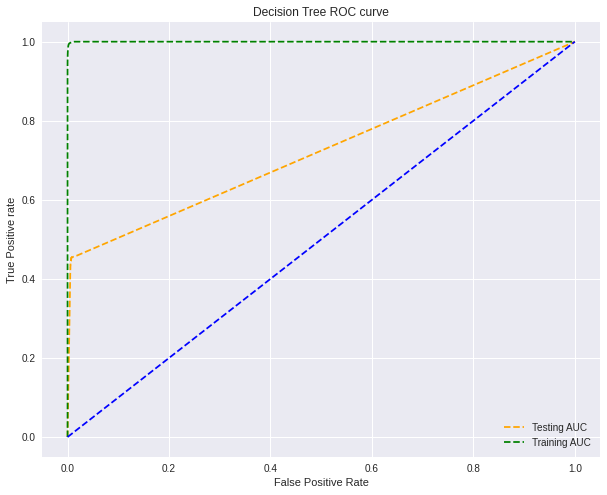

In [ ]:
# roc curve for models
fpr_tree_test, tpr_tree_test, thresh1 = roc_curve(label_encoded_y_test, tree_test_predictions_proba[:,1], pos_label=1)
fpr_tree_train, tpr_tree_train, thresh2 = roc_curve(label_encoded_y_train, tree_train_predictions_proba[:,1], pos_label=1)

# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(label_encoded_y_test))]
# # p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

#plot
plt.style.use('seaborn')
plt.figure(figsize=(10,8))

plt.plot(fpr_tree_test, tpr_tree_test, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr_tree_train, tpr_tree_train, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
plt.title('Decision Tree ROC curve')
# # x label
plt.xlabel('False Positive Rate')
# # y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('Decision_tree_ROC',dpi=300)
plt.show();

**Finding the best depth/ Tune Hyperparameters**

In [ ]:
tree_clf= DecisionTreeClassifier(random_state=0)

#Grid Search space
param_grid = {'max_depth':[5,6,7,8,9,10,11],
              'min_samples_split':[1,2,3,4]}      

In [ ]:
#import the grid search class
from sklearn.model_selection import GridSearchCV

#fit the grid search over all specified combination of parameters
grid = GridSearchCV(tree_clf, param_grid = param_grid, cv=kfold , scoring= 'roc_auc', n_jobs=-1)
grid.fit(X_train_preprocessed,label_encoded_y_train)

#print best parameters
grid.best_params_

{'max_depth': 8, 'min_samples_split': 4}

In [ ]:
#create training and testing predictions probabilities
grid_tree_train_predictions_proba = grid.predict_proba(X_train_preprocessed)
grid_tree_test_predictions_proba = grid.predict_proba(X_test_preprocessed)

#create training and testing predictions
grid_tree_train_predictions= grid.predict(X_train_preprocessed)
grid_tree_test_predictions= grid.predict(X_test_preprocessed)

#calculate training and testing AUC Scores 
grid_tree_train_auc= roc_auc_score(label_encoded_y_train,grid_tree_train_predictions_proba[:,1])
grid_tree_test_auc= roc_auc_score(label_encoded_y_test,grid_tree_test_predictions_proba[:,1])

#display the training and testing AUC
print(f"Training AUC with Best Params: {grid_tree_train_auc}")
print(f"Testing AUC with Best Params: {grid_tree_test_auc}")

#cross_val_score(tree_clf,X_train_preprocessed,label_encoded_y_train,cv=kfold, scoring='roc_auc')

Training AUC with Best Params: 0.9364450013819682
Testing AUC with Best Params: 0.9268455164927026


**Plot ROC Curve**

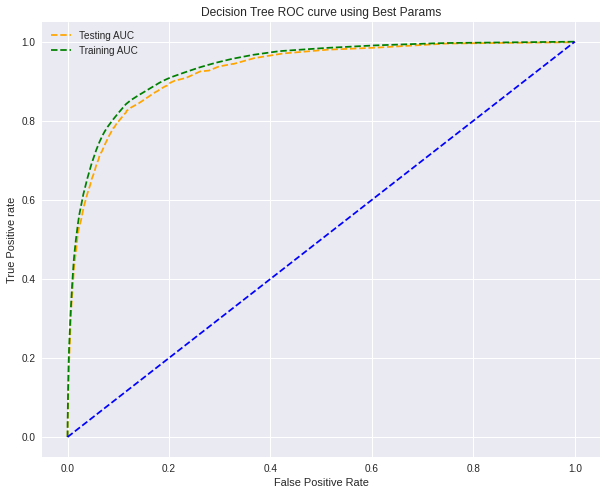

In [ ]:
# roc curve for models
best_params_fpr_tree_test, best_params_tpr_tree_test, thresh1 = roc_curve(label_encoded_y_test, grid_tree_test_predictions_proba[:,1], pos_label=1)
best_params_fpr_tree_train_grid, best_params_tpr_tree_train, thresh2 = roc_curve(label_encoded_y_train, grid_tree_train_predictions_proba[:,1], pos_label=1)

# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(label_encoded_y_test))]
# # p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

#plot
plt.style.use('seaborn')
plt.figure(figsize=(10,8))

plt.plot(best_params_fpr_tree_test, best_params_tpr_tree_test, linestyle='--',color='orange', label='Testing AUC')
plt.plot(best_params_fpr_tree_train_grid, best_params_tpr_tree_train, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
plt.title('Decision Tree ROC curve using Best Params')
# # x label
plt.xlabel('False Positive Rate')
# # y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('Best_Params_Decision_tree_ROC',dpi=300)
plt.show();

In [ ]:
# best_depth = np.argmax(validation_auc)   #find the max_depth corresponding to the best AUC
# best_auc = np.max(validation_auc)

# print(f"The depth for the best performance is: {best_depth}")
# print(f"The auc for the best performance is: {best_auc}")
best_params = grid.best_params_
best_params
#best_params={'max_depth': 8, 'min_samples_split': 4}

{'max_depth': 8, 'min_samples_split': 4}

**Check for model generalization on the test data**

In [ ]:
#Fit with the best max_depth and predict the test set
tree_clf = DecisionTreeClassifier(**best_params,random_state=0)
tree_clf.fit(X_train_preprocessed,label_encoded_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
#create testing predictions and probabilities
#predict testing values
tree_testing_predictions1= tree_clf.predict(X_test_preprocessed)

#predict testing probabilities
tree_testing_predictions_proba1 = tree_clf.predict_proba(X_test_preprocessed)

#calculate testing AUC Score 
tree_testing_auc= roc_auc_score(label_encoded_y_test,tree_testing_predictions_proba1[:,1])
tree_testing_auc

0.9268455164927026

In [ ]:
#get confusion matrix
confusion_matrix(label_encoded_y_test,tree_testing_predictions1)

array([[207834,    101],
       [  1691,     89]])

**XGBoost**

**Using Stratified K Fold Cross-Validation**

In [ ]:
xgb_training_auc_list = []
xgb_validation_auc_list=[]
i=1
#Split into traning and validation using Stratified KFold
for train_index, val_index in kfold.split(X_train_preprocessed,label_encoded_y_train):
    X_train, X_val =X_train_preprocessed[train_index], X_train_preprocessed[val_index]
    y_train, y_val = label_encoded_y_train[train_index], label_encoded_y_train[val_index]

    #initialize XGBoost
    xgb_clf = XGBClassifier(n_jobs=-1, random_state=0)

    #Fit on training data
    eval_set = [(X_train, y_train), (X_val,y_val)]
    xgb_clf.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set , verbose=False)

    #make predictions on the training and validation set 
    #training predictions
    xgb_train_predict_proba = xgb_clf.predict_proba(X_train)
    xgb_training_auc= roc_auc_score(y_train,xgb_train_predict_proba[:,1])

    #validation predictions
    xgb_val_predict_proba = xgb_clf.predict_proba(X_val)
    xgb_validation_auc= roc_auc_score(y_val,xgb_val_predict_proba[:,1])

    #append training and testing auc
    xgb_training_auc_list.append(xgb_training_auc)
    xgb_validation_auc_list.append(xgb_validation_auc)

    #print training and validation auc
    print(f"{i}--Fold")
    print(f"Training AUC: {xgb_training_auc}")
    print(f"Validation AUC: {xgb_validation_auc}")

    i = i+1

    print('\n')

print(f"Mean Training AUC Score : {np.mean(xgb_training_auc_list)}")
print(f"Mean Validation AUC Score : {np.mean(xgb_validation_auc_list)}")


1--Fold
Training AUC: 0.9420943271466927
Validation AUC: 0.942767531492123


2--Fold
Training AUC: 0.9436365570085172
Validation AUC: 0.9368987999436945


3--Fold
Training AUC: 0.9427506930294263
Validation AUC: 0.9412646094501227


4--Fold
Training AUC: 0.9422069255106071
Validation AUC: 0.9408313681714493


5--Fold
Training AUC: 0.9429295646580336
Validation AUC: 0.9378643834990029


Mean Training AUC Score : 0.9427236134706554
Mean Validation AUC Score : 0.9399253385112785


**Train on the whole training datastet and Evaluate on Test Data**

In [ ]:
xgb_clf= XGBClassifier(random_state=0, n_jobs=-1)
eval_set = [(X_train_preprocessed, label_encoded_y_train), (X_test_preprocessed, label_encoded_y_test)]
xgb_clf.fit(X_train_preprocessed, label_encoded_y_train, eval_metric='auc', eval_set=eval_set, verbose=True) 

#create training and testing predictions probabilities
xgb_train_predictions_proba = xgb_clf.predict_proba(X_train_preprocessed)
xgb_test_predictions_proba = xgb_clf.predict_proba(X_test_preprocessed)

#create training and testing predictions
xgb_train_predictions= xgb_clf.predict(X_train_preprocessed)
xgb_test_predictions= xgb_clf.predict(X_test_preprocessed)

#calculate training and testing AUC Scores 
xgb_train_auc= roc_auc_score(label_encoded_y_train,xgb_train_predictions_proba[:,1])
xgb_test_auc= roc_auc_score(label_encoded_y_test,xgb_test_predictions_proba[:,1])

#display the training and testing AUC
print(f"Training AUC: {xgb_train_auc}")
print(f"Testing AUC: {xgb_test_auc}")


[0]	validation_0-auc:0.863927	validation_1-auc:0.864893
[1]	validation_0-auc:0.877588	validation_1-auc:0.877998
[2]	validation_0-auc:0.880455	validation_1-auc:0.880829
[3]	validation_0-auc:0.882729	validation_1-auc:0.883
[4]	validation_0-auc:0.882721	validation_1-auc:0.883043
[5]	validation_0-auc:0.883065	validation_1-auc:0.88324
[6]	validation_0-auc:0.882962	validation_1-auc:0.883143
[7]	validation_0-auc:0.883091	validation_1-auc:0.883261
[8]	validation_0-auc:0.883182	validation_1-auc:0.883409
[9]	validation_0-auc:0.883694	validation_1-auc:0.884051
[10]	validation_0-auc:0.883832	validation_1-auc:0.884283
[11]	validation_0-auc:0.883755	validation_1-auc:0.884149
[12]	validation_0-auc:0.883725	validation_1-auc:0.884111
[13]	validation_0-auc:0.884178	validation_1-auc:0.88477
[14]	validation_0-auc:0.884686	validation_1-auc:0.885216
[15]	validation_0-auc:0.884978	validation_1-auc:0.885603
[16]	validation_0-auc:0.884907	validation_1-auc:0.885581
[17]	validation_0-auc:0.887501	validation_1-au

**Visualize result**

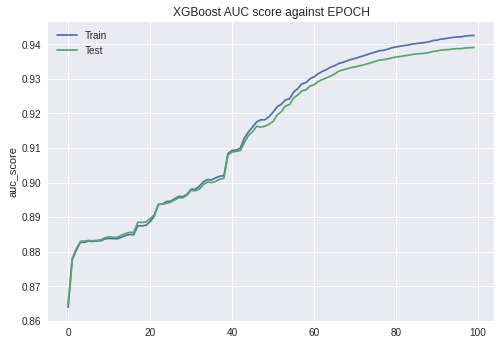

In [ ]:
#Evaluate result
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot auc score 
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc_score')
plt.title('XGBoost AUC score against EPOCH')
plt.show()


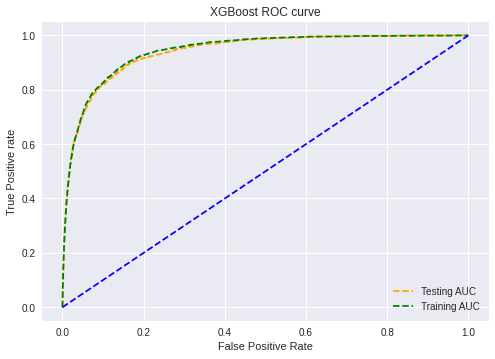

In [ ]:
#plot ROC Curve
# roc curve for models
fpr_xgb_test, tpr_xgb_test, thresh1 = roc_curve(label_encoded_y_test, xgb_test_predictions_proba[:,1], pos_label=1)
fpr_xgb_train, tpr_xgb_train, thresh2 = roc_curve(label_encoded_y_train, xgb_train_predictions_proba[:,1], pos_label=1)

# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(label_encoded_y_test))]
# # p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

#plot
#plt.figure(figsize=(10,8))
plt.plot(fpr_xgb_test, tpr_xgb_test, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr_xgb_train, tpr_xgb_train, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
plt.title('XGBoost ROC curve')
# # x label
plt.xlabel('False Positive Rate')
# # y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('XGB_ROC',dpi=300)
plt.show();

**Feature Selection**

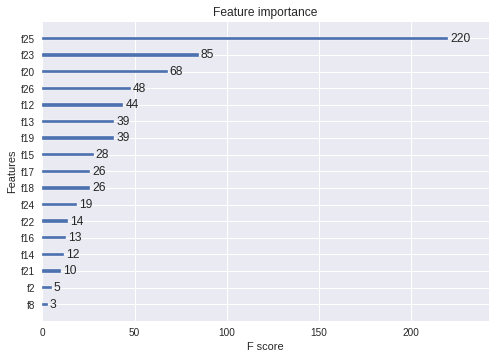

In [ ]:
from xgboost import plot_importance

##plot mportant features
plot_importance(xgb_clf)

In [ ]:
xgb_clf.feature_importances_

array([0.        , 0.        , 0.02144509, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.015584  , 0.        ,
       0.        , 0.        , 0.02621527, 0.11876731, 0.02554181,
       0.01972383, 0.02815592, 0.03634098, 0.08050394, 0.0622323 ,
       0.08911533, 0.13630688, 0.02289104, 0.13181244, 0.02269756,
       0.08560806, 0.07705822], dtype=float32)

**Tune Hyperparameters**



First approach  : Tune individual parameters

***Number of Trees***

In [ ]:
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)

In [ ]:
model = XGBClassifier(random_state=0,n_jobs=-1, seed=0)
xgb_grid = GridSearchCV(model, param_grid = param_grid, cv=kfold , scoring= 'roc_auc', n_jobs=-1)
xgb_grid.fit(X_train_preprocessed,label_encoded_y_train)
xgb_grid.best_params_

{'n_estimators': 350}

{'n_estimators': 350}

Best: 0.947881 using {'n_estimators': 350}
0.917724 (0.003191) with: {'n_estimators': 50}
0.939925 (0.002195) with: {'n_estimators': 100}
0.943660 (0.002189) with: {'n_estimators': 150}
0.945170 (0.002149) with: {'n_estimators': 200}
0.946280 (0.001973) with: {'n_estimators': 250}
0.947183 (0.001914) with: {'n_estimators': 300}
0.947881 (0.001865) with: {'n_estimators': 350}


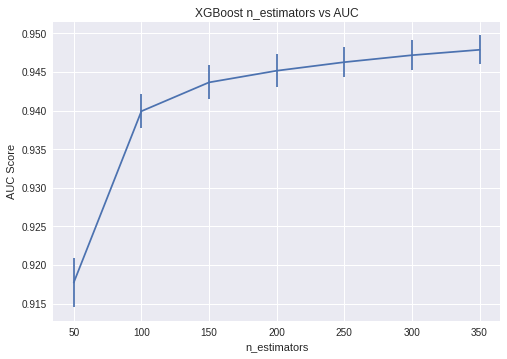

In [ ]:
# summarize results
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
   print("%f (%f) with: %r" % (mean, stdev, param))
 # plot
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs AUC")
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.savefig('n_estimators.png')

**Tune Maximum Depth and Number of Estimators**

In [ ]:
max_depth = [3,4,5,6,7,8,9]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators =[100,150,200,250,300])

model = XGBClassifier(random_state=0,n_jobs=-1, seed=0)
xgb_grid = GridSearchCV(model, param_grid = param_grid, cv=kfold , scoring= 'roc_auc', n_jobs=-1)
xgb_grid.fit(X_train_preprocessed,label_encoded_y_train)
xgb_grid.best_params_


[3, 4, 5, 6, 7, 8, 9]


In [ ]:
# summarize results
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
   print("%f (%f) with: %r" % (mean, stdev, param))

# plot Error bar
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost Maximum depth vs AUC")
plt.xlabel('Maximum Depth')
plt.ylabel('AUC Score')
plt.savefig('Max_depth.png')

In [ ]:
max_depth : range(1, 11, 2)
Best: 0.961249 using {'max_depth': 9}
0.914056 (0.002648) with: {'max_depth': 1}
0.939964 (0.002144) with: {'max_depth': 3}
0.947964 (0.002323) with: {'max_depth': 5}
0.955014 (0.001771) with: {'max_depth': 7}
0.961249 (0.001529) with: {'max_depth': 9}

In [ ]:
model1 = XGBClassifier(n_estimators=350,,random_state=0 , n_jobs=-1 , seed=0)
cross_val_score(model1,X_train_preprocessed,label_encoded_y_train,cv=kfold, scoring='roc_auc').mean()

**Tune all parameters at once** 

This has a high computational cost

In [ ]:
param_grid = {'max_depth':[1,2,3,4,5], 
           'learning_rate':[0.001, 0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ], 
           'n_estimators':[5,10,20,30,40,50,100,150], 
           'min_child_weight':[1,3,5,7],
           'subsample':[0.5,0.6,0.7,0.8,0.9,1.0], 
           'colsample_bytree':[ 0.3, 0.4, 0.5 ,0.6, 0.7,0.8,0.9,1.0 ], 
           'gamma':[0,0.1,0.2]}

**Random Forest**

In [ ]:
# Split the training dataset into training and validation dataset
#using a stratified CV=5
rfc_training_auc_list = []
rfc_validation_auc_list = []

#For each folds in Kfolds, selects n-1 folds as the training set and the last fold as the validation set
for train_index, val_index in kfold.split(X_train_preprocessed,label_encoded_y_train):
    X_train_cv, X_val_cv =X_train_preprocessed[train_index], X_train_preprocessed[val_index]
    y_train_cv, y_val_cv = label_encoded_y_train[train_index], label_encoded_y_train[val_index]
  
    #initialize logistic regression
    rfc= RandomForestClassifier(random_state=0 , verbose=1, n_jobs=-1)

    #Training with the training split 
    rfc.fit(X_train_cv,y_train_cv)

    #create training and validation predictions probabilities
    rfc_train_predictions_proba = rfc.predict_proba(X_train_cv)
    rfc_val_predictions_proba = rfc.predict_proba(X_val_cv)

    #create training and validation predictions 
    rfc_train_predictions= rfc.predict(X_train_cv)
    rfc_val_predictions= rfc.predict(X_val_cv)
                                     
    #calculate testing AUC Scores
    # We chose AUC because of the imbalance dataset
    rfc_training_auc= roc_auc_score(y_train_cv,rfc_train_predictions_proba[:,1])
    rfc_validation_auc= roc_auc_score(y_val_cv,rfc_val_predictions_proba[:,1])

    #append training and validation auc into list
    rfc_training_auc_list.append(rfc_training_auc)
    rfc_validation_auc_list.append(rfc_validation_auc)

    #view the training and validation AUC
    print(f'Training AUC: {rfc_training_auc}')
    print(f'Validation AUC: {rfc_validation_auc}')

print('\n')


#view training and validation auc
print(f'Training AUC List: {rfc_training_auc_list}')
print(f'Validation AUC List: {rfc_validation_auc_list}')

print('\n')
#Get the mean training and validtaion auc score
print(f'Mean training auc score: {np.mean(rfc_training_auc_list)}')
print(f'Mean validation auc score: {np.mean(rfc_validation_auc_list)}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_

Training AUC: 0.9993948506792177
Validation AUC: 0.954413654919442


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_

Training AUC: 0.9994503324626348
Validation AUC: 0.9546770862687213


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_

Training AUC: 0.9994907582029284
Validation AUC: 0.9577991835276689


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_

Training AUC: 0.9994257324076667
Validation AUC: 0.9553927347853141


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_

Training AUC: 0.9994436810073415
Validation AUC: 0.9579828908153288


Training AUC List: [0.9993948506792177, 0.9994503324626348, 0.9994907582029284, 0.9994257324076667, 0.9994436810073415]
Validation AUC List: [0.954413654919442, 0.9546770862687213, 0.9577991835276689, 0.9553927347853141, 0.9579828908153288]


Mean training auc score: 0.9994410709519578
Mean validation auc score: 0.956053110063295


**Train on whole training set and predict on the test set**

In [ ]:
#initiate a random forest classifier
rf_clf = RandomForestClassifier(random_state=0 , verbose=1, n_jobs=-1)

#fit on the training dataset
rf_clf.fit(X_train_preprocessed,label_encoded_y_train)

#create training and testing predictions probabilities
rf_clf_train_predictions_proba = rf_clf.predict_proba(X_train_preprocessed)
rf_clf_test_predictions_proba = rf_clf.predict_proba(X_test_preprocessed)

#create training and testing predictions
rf_clf_train_predictions= rf_clf.predict(X_train_preprocessed)
rf_clf_test_predictions= rf_clf.predict(X_test_preprocessed)

#calculate training and testing AUC Scores 
rf_clf_train_auc= roc_auc_score(label_encoded_y_train,rf_clf_train_predictions_proba[:,1])
rf_clf_test_auc= roc_auc_score(label_encoded_y_test,rf_clf_test_predictions_proba[:,1])

#display the training and testing AUC
print(f"Training AUC: {rf_clf_train_auc}")
print(f"Testing AUC: {rf_clf_test_auc}")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_

Training AUC: 0.9994337156632245
Testing AUC: 0.9619925319683146


**Plot ROC Curve**

NameError: ignored

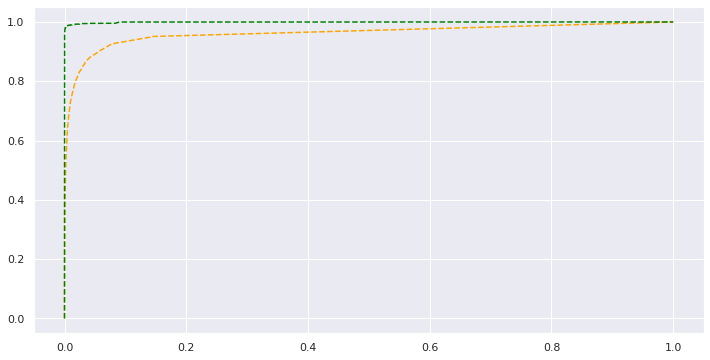

In [ ]:
from sklearn.metrics import roc_curve

#plot ROC Curve
# roc curve for models
fpr_rfc_test, tpr_rfc_test, thresh1 = roc_curve(label_encoded_y_test, rf_clf_test_predictions_proba[:,1], pos_label=1)
fpr_rfc_train, tpr_rfc_train, thresh2 = roc_curve(label_encoded_y_train, rf_clf_train_predictions_proba[:,1], pos_label=1)

# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(label_encoded_y_test))]
# # p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

#plot
#plt.figure(figsize=(10,8))
plt.plot(fpr_rfc_test, tpr_rfc_test, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr_rfc_train, tpr_rfc_train, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
plt.title('Random Forest ROC curve')
# # x label
plt.xlabel('False Positive Rate')
# # y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('rfc_ROC',dpi=300)
plt.show();

In [ ]:
#get the confusion matrix 
confusion_matrix(label_encoded_y_test,rf_clf_test_predictions)

array([[207864,     71],
       [  1302,    478]])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.6s finished


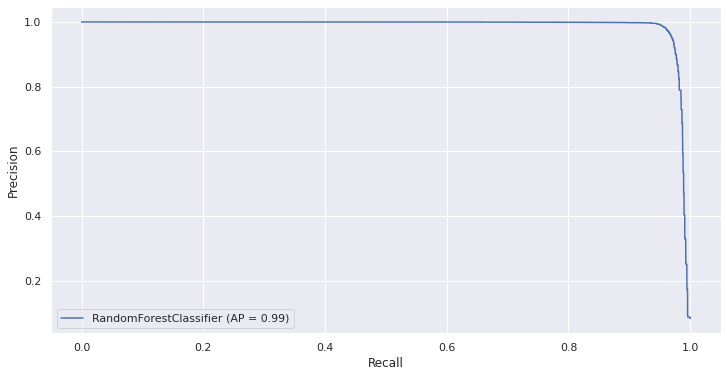

In [ ]:
#plot the precision recall curve
plot_precision_recall_curve(rf_clf,X_train_preprocessed, label_encoded_y_train)

In [ ]:
#To see the performance summary of the random forest classifier on unseen test dataset
#we print the classification report

target_names = ['class 0', 'class 1']
print(classification_report(label_encoded_y_test,rf_clf_test_predictions,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00    207935
     class 1       0.87      0.27      0.41      1780

    accuracy                           0.99    209715
   macro avg       0.93      0.63      0.70    209715
weighted avg       0.99      0.99      0.99    209715



**Parameter Tuning**

**Using Random SearchCV**

In [ ]:
n_estimators= [500, 800, 1200]
max_depth= [5, 8, 15, 25 ]
min_samples_split= [1, 2, 5, 10, 15, 100]
min_samples_leaf= [1, 2, 5, 10]



#Attempt 2

max_features = ['log2','auto','auto']


In [ ]:
#impport RandomSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

random_forest_clf = RandomForestClassifier(n_jobs=-1, random_state=0)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_search = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = param_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=0, n_jobs = -1)


# Fit the random search model
rf_random_search.fit(X_train_preprocessed, label_encoded_y_train)

#display best params
rf_random_search.best_params_

#get best hyperparamaters
print("Best parameters set:")
best_paramameters =rf_random_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
  print(f"\t{param_name}: {best_parameters[param_name]}")



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


**Using Grid SearchCV**

In [ ]:
# from sklearn.model_selection import GridSearchCV

num_estimators= [9,10,15,20]
max_depth=[5,5.5,6,6.5,7]
min_samples_leaf =[4.5,5,5.5,6]

param_grid = dict(max_depth=max_depth, n_estimators=num_estimators, min_samples_leaf=min_samples_leaf)

rfc = RandomForestClassifier(random_state=0,n_jobs=-1)
rfc_grid = GridSearchCV(rfc, param_grid = param_grid, cv=kfold , scoring= 'roc_auc', n_jobs=-1)
rfc_grid.fit(X_train_preprocessed,label_encoded_y_train)
rfc_grid.best_params_

In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
# print(random_grid)


# print('\n')

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random_search = RandomizedSearchCV(estimator = rfc, 
#                                param_distributions = random_grid, n_iter = 100, 
#                                cv = 3, verbose=2, random_state=0, n_jobs = -1)


# # Fit the random search model
# rf_random_search.fit(X_train_preprocessed, label_encoded_y_train)

# #display best params
# rf_random_search.best_params_

# #get best hyperparamaters
# best_params =rf_random_search.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
best_params= {'max_depth': 10, 'n_estimators': 20}  #'min_samples_leaf': 6, 

**Fit All training datasets using the best paramaters**

In [ ]:
rfc_best_params = RandomForestClassifier(**best_params,random_state=0, n_jobs=-1)

#fit on all training set
rfc_best_params.fit(X_train_preprocessed, label_encoded_y_train)

#create training and testing predictions probabilities
rfc_best_params_train_predictions_proba = rfc_best_params.predict_proba(X_train_preprocessed)
rfc_best_params_test_predictions_proba = rfc_best_params.predict_proba(X_test_preprocessed)

#create training and testing predictions
rfc_best_params_train_predictions= rfc_best_params.predict(X_train_preprocessed)
rfc_best_params_test_predictions= rfc_best_params.predict(X_test_preprocessed)

#calculate training and testing AUC Scores 
rfc_best_params_train_auc= roc_auc_score(label_encoded_y_train,rfc_best_params_train_predictions_proba[:,1])
rfc_best_params_test_auc= roc_auc_score(label_encoded_y_test,rfc_best_params_test_predictions_proba[:,1])

#display the training and testing AUC
print(f"Training AUC with Best Params: {rfc_best_params_train_auc}")
print(f"Testing AUC with Best Params: {rfc_best_params_test_auc}")

#cross_val_score(tree_clf,X_train_preprocessed,label_encoded_y_train,cv=kfold, scoring='roc_auc')


Training AUC with Best Params: 0.963068582382324
Testing AUC with Best Params: 0.947888928124957


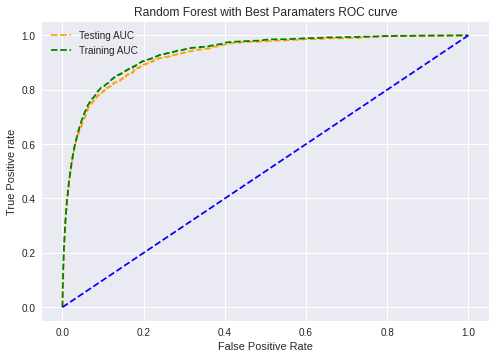

In [ ]:
#plot ROC Curve
# roc curve for models
fpr_rfc_test, tpr_rfc_test, thresh1 = roc_curve(label_encoded_y_test, rfc_best_params_test_predictions_proba[:,1], pos_label=1)
fpr_rfc_train, tpr_rfc_train, thresh2 = roc_curve(label_encoded_y_train, rfc_best_params_train_predictions_proba[:,1], pos_label=1)

# # roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(label_encoded_y_test))]
# # p_fpr, p_tpr, _ = roc_curve(label_encoded_y_test, random_probs, pos_label=1)

#plot
#plt.figure(figsize=(10,8))
plt.plot(fpr_rfc_test, tpr_rfc_test, linestyle='--',color='orange', label='Testing AUC')
plt.plot(fpr_rfc_train, tpr_rfc_train, linestyle='--',color='green', label='Training AUC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
plt.title('Random Forest with Best Paramaters ROC curve')
# # x label
plt.xlabel('False Positive Rate')
# # y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('best_params_rfc_ROC',dpi=300)
plt.show();

**Comment** : The perfomance using the best hyperparameter is not as good as  the previous one (using the default hyperparamter) . We suspect there might be other hyperparemeters that will produce a better performance . Due to the computational limitation of our computer , We will do this as future work.

**Compare Roc_AUC Curve of all classifiers**

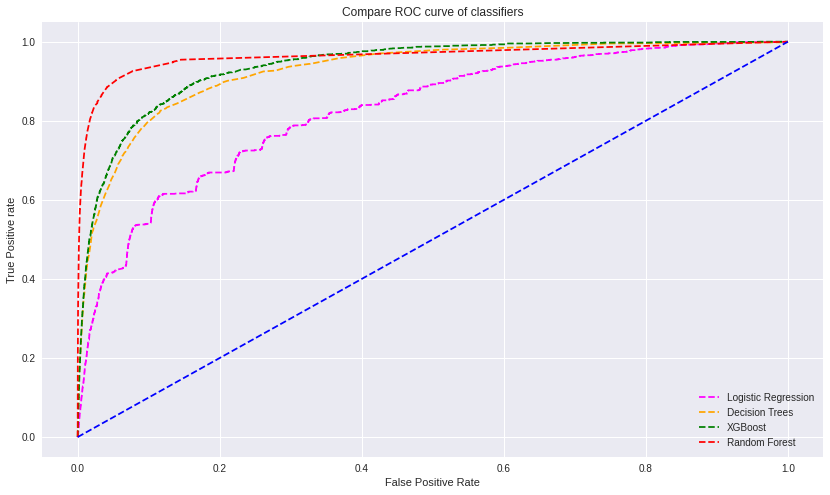

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(14,8))
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='magenta', label='Logistic Regression')
plt.plot(best_params_fpr_tree_test, best_params_tpr_tree_test, linestyle='--',color='orange', label='Decision Trees')
plt.plot(fpr_xgb_test, tpr_xgb_test, linestyle='--',color='green', label='XGBoost')
plt.plot(fpr_rfc_test, tpr_rfc_test, linestyle='--',color='red', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Compare ROC curve of classifiers')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best', )
plt.savefig('Compare_ROC',dpi=300)
plt.show();

In [ ]:
!jupyter nbconvert Product_Backorder.ipynb

[NbConvertApp] Converting notebook Product_Backorder.ipynb to html
[NbConvertApp] Writing 1097347 bytes to Product_Backorder.html


In [ ]:
!pip install nbconvert


You should consider upgrading via the 'c:\users\olatu\anaconda3\python.exe -m pip install --upgrade pip' command.
